In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import os

In [3]:
mdiri = '/oldhome/apbarret/projects/ancillary/masks'
mfili = 'arctic_mask_1x1deg.nc'

In [135]:
def global_mask(type=None):
    
    ds = xr.open_dataset(os.path.join(mdiri, mfili))
    mask = ds['arctic_mask']
    
    if type == 'arcticocean':
        return mask.where(mask >= 6)*0+1
    else:
        return mask
        

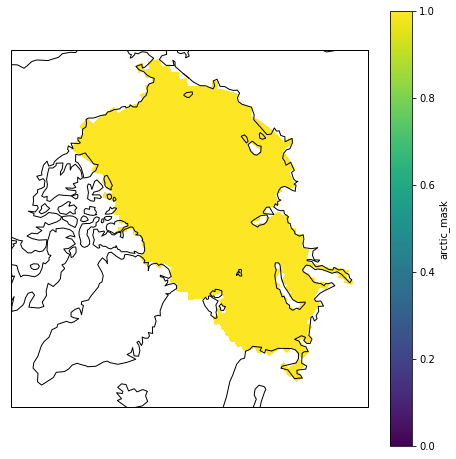

In [51]:
fig = plt.figure(figsize=(8,8))

ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,65,90], ccrs.PlateCarree())
ax.coastlines()
global_mask(type='arcticocean').plot(ax=ax, vmin=0, vmax=1, transform=ccrs.PlateCarree())


In [53]:
mask = global_mask(type='arcticocean')
#mask.sel(lon=slice(10,30), lat=slice(65.,75.))
mask

<xarray.DataArray 'arctic_mask' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...

## Get lat and lon for NRims50km EASE grid

In [107]:
GridFile = "/oldhome/apbarret/projects/ancillary/maps/ease_nh50km_coordinates.nc"
grid_ds = xr.open_dataset(GridFile)
lat = grid_ds['lat2d']
lon = grid_ds['lon2d']

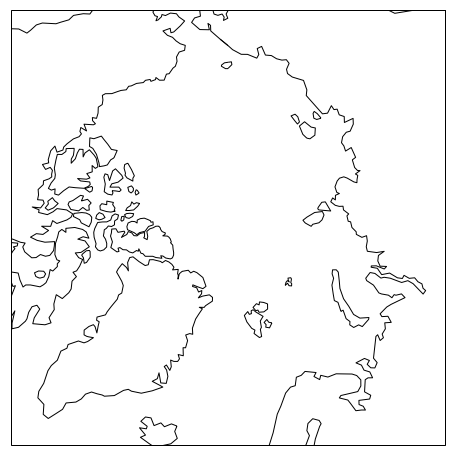

In [108]:
fig = plt.figure(figsize=(8,8))

ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,65,90], ccrs.PlateCarree())
ax.coastlines()

#plt.plot(lon, lat, '+', color='k', transform=ccrs.PlateCarree())

In [121]:

idx.shape

(101468,)

In [129]:
i = np.floor(x).astype(int)
j = np.floor(y+90.).astype(int)
mval = mask.data[j,i]

emask = np.full(lon.size, np.nan)
emask[idx] = mval
emask = emask.reshape(lon.shape)


(360, 360)


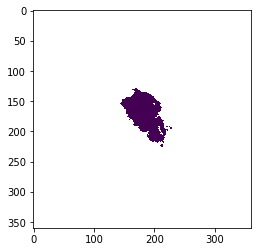

In [130]:
plt.imshow(emask)

In [143]:
def landsea_mask(lon, lat, type=None):
    
    mask = global_mask(type=type)
    
    # reorder lat and lon
    x = lon.data.flatten()
    y = lat.data.flatten()
    idx = np.argwhere(x > -998.).reshape(-1)
    
    # Calculate indices for mask grid
    i = np.floor(x[idx]).astype(int)
    j = np.floor(y[idx]+90.).astype(int)
    
    # Extract mask and reshape
    result = np.full(lon.size, np.nan)
    result[idx] = mask.data[j,i]
    
    ni, nj = lon.shape
    ds = xr.Dataset({'mask': (['row', 'col'], result.reshape(lon.shape))},
                     coords={'lat': (['row', 'col'], lat), 
                             'lon': (['row', 'col'], lon)})

    return ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mask     float64 7.0


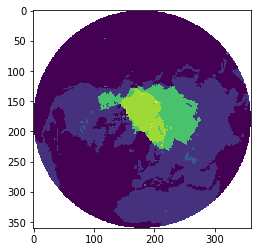

In [147]:
emask = landsea_mask(lon, lat)
plt.imshow(emask['mask'])
print (emask.max())

In [148]:
# projection class
class EASE_North(ccrs.Projection):

    def __init__(self):

        # see: http://www.spatialreference.org/ref/epsg/3408/
        proj4_params = {'proj': 'laea',
            'lat_0': 90.,
            'lon_0': 0,
            'x_0': 0,
            'y_0': 0,
            'a': 6371228,
            'b': 6371228,
            'units': 'm',
            'no_defs': ''}

        super(EASE_North, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 1e5

    @property
    def x_limits(self):
        #return (-9030575.88125, 9030575.88125)
        #return (-9000000, 9000000)
        return (-8999241.475, 8999241.475)
    @property
    def y_limits(self):
        #return (-9030575.88125, 9030575.88125)
        #return (-9000000, 9000000)
        return (-8999241.475, 8999241.475)

def get_projection_info():

    # Define extent
    C= 200.5402*1e3/4.
    r0 = 179.5
    extent = [-1*r0*C, r0*C, -1*r0*C, r0*C]

    origin = 'upper'

    projection = EASE_North()

    return extent, origin, projection

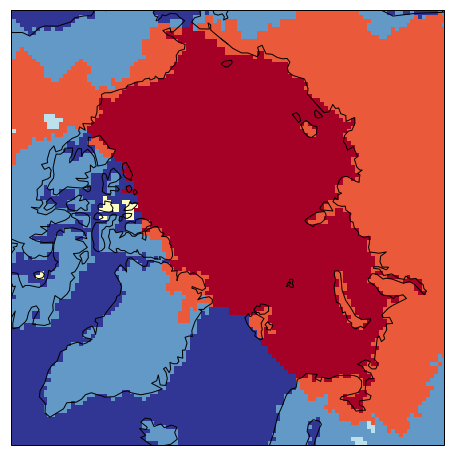

In [153]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.colors as colors

extent, origin, projection = get_projection_info()

lim = 3000000
fig, ax = plt.subplots(figsize=(8,8),
                        subplot_kw={'projection': EASE_North(),
                                    'xlim': [-lim,lim],
                                    'ylim': [-lim,lim]})

ax.coastlines()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())

cmap = plt.get_cmap('RdYlBu_r')
bounds = np.arange(0,8)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

img = ax.imshow(emask['mask'], cmap=cmap, norm=norm, 
                interpolation='none', origin=origin, extent=extent, transform=projection)
